In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Part 1 : Grayscale image

##Cluster centers
For grayscale images, a cluster center is simply an intensity value that represents the "typical" or "average" intensity of all pixels belonging to that cluster.
###The Formula:
From the document, the formula for calculating cluster center c_j is:

c_j = Σ(u_ij^m * x_i) / Σ(u_ij^m)
Where:

* c_j = center of cluster j
* u_ij = membership of pixel i to cluster j
* m = fuzziness parameter (usually 2)
* x_i = intensity value of pixel i

In [2]:
def calculate_cluster_centers(U, points, k, m):
    C = np.zeros(k)
    for j in range(k):
      weights = U[:,j] ** m
      C[j] = np.sum(weights*points[:])/np.sum(weights)

    return C

##Update the membership matrix U
###The Formula:
From the document, the update formula for membership u_ij is:

u_ij = 1 / Σ(||x_i - c_j|| / ||x_i - c_k||)^(2/(m-1))

Where the sum is over all clusters k (from 1 to K).

##What this means:
For each pixel i and each cluster j:

* Calculate the distance from pixel i's intensity to cluster center j: ||x_i - c_j|| we'll call it d_1
* Calculate the distance from pixel i's intensity to all cluster centers k we'll call it d_2
* Compute the ratio of distances raised to power 2/(m-1)
* Sum these ratios over all clusters
* Take the inverse

In [3]:
def update_membership_matrix(U, points, C, k, m):
  for i in range(points.shape[0]):
    for j in range(k):
      d_1 = np.abs(points[i] - C[j])

      sum_ratios = 0
      for l in range(k):
        d_2 = np.abs(points[i] - C[l])

        if d_2 == 0:  # pixel exactly at cluster center
          sum_ratios = float('inf')  # will make U[i,j] = 0 for j!=l
          break

        ratio = (d_1 / d_2)**(2/(m-1))
        sum_ratios += ratio

      if d_1 == 0:  # pixel exactly at cluster j
          U[i, j] = 1.0
      else:
          U[i, j] = 1.0 / sum_ratios

  return U

## FCM
### The flow:

* Save old U
* Calculate centers from current U
* Update U based on new centers
* Check if U changed much
* If difference < ε or Max Itter then STOP
* Repeat

In [4]:
def FCM(points,U, k, m, max_iter=100, tol=1e-4):
  for i in range(max_iter):
    # saving current U
    U_old = U.copy()

    C = calculate_cluster_centers(U, points,k,m)

    U = update_membership_matrix(U, points, C, k, m)

    # check convergence
    if np.max(np.abs(U - U_old)) < tol:
      print(f"Converged at iteration {i}")
      break

  return U, C

## Visualisation

In [5]:
def visualize_fcm_results(image_array, U_final, C_final, k):
    plt.figure(figsize=(16, 8))

    # 1. Original image
    plt.subplot(1, k+2, 1)
    plt.imshow(image_array, cmap='gray', vmin=0, vmax=255)
    plt.title('Original Image')
    plt.axis('off')

    # 2. Segmented image (hard clustering)
    labels = np.argmax(U_final, axis=1)
    segmented = labels.reshape(image_array.shape)

    plt.subplot(1, k+2, 2)
    plt.imshow(segmented, cmap='viridis')
    plt.title(f'Segmented Image\nCenters: {C_final.round(2)}')
    plt.axis('off')

    # 3. Heatmap for each cluster
    for j in range(k):
        plt.subplot(1, k+2, j+3)
        membership_j = U_final[:, j].reshape(image_array.shape)
        plt.imshow(membership_j, cmap='hot', vmin=0, vmax=1)
        plt.title(f'Membership to Cluster {j}\n(Center: {C_final[j]:.2f})')
        plt.colorbar()
        plt.axis('off')

    plt.tight_layout()
    plt.show()

##Plot

In [6]:
def plot_membership_functions(points, U_final, C_final, k):
    plt.figure(figsize=(12, 6))

    # Get unique intensity values and their average memberships
    unique_intensities = np.unique(points)

    for j in range(k):
        # For each intensity value, calculate average membership to cluster j
        avg_membership = []
        for intensity in unique_intensities:
            mask = points == intensity
            avg_membership.append(np.mean(U_final[mask, j]))

        plt.plot(unique_intensities, avg_membership,
                label=f'Cluster {j} (Center: {C_final[j]:.2f})',
                linewidth=2, marker='o', markersize=2)

    # Add cluster centers as vertical lines
    for j in range(k):
        plt.axvline(C_final[j], color=f'C{j}', linestyle='--', alpha=0.5)

    plt.xlabel('Pixel Intensity')
    plt.ylabel('Membership Degree')
    plt.title('Fuzzy Membership Functions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.05, 1.05)
    plt.xlim(0, 255)
    plt.show()

## Main

###Load grayscale image

In [7]:
image_path = "/content/milky-way.jpg"

In [8]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_array = np.array(image)
points = image_array.flatten()

points.shape

(1048576,)

###Initialize U matrix

In [9]:
k = 3
m = 2

In [10]:
U = np.random.rand(points.shape[0],k)
U = U / U.sum(axis=1, keepdims=True)

###FCM algo

In [11]:
U_final, C_final = FCM(points, U, k, m)

print(f"Final cluster centers: {C_final}")

Converged at iteration 48
Final cluster centers: [144.36233305  82.7657111   22.85242628]


###Visualize results

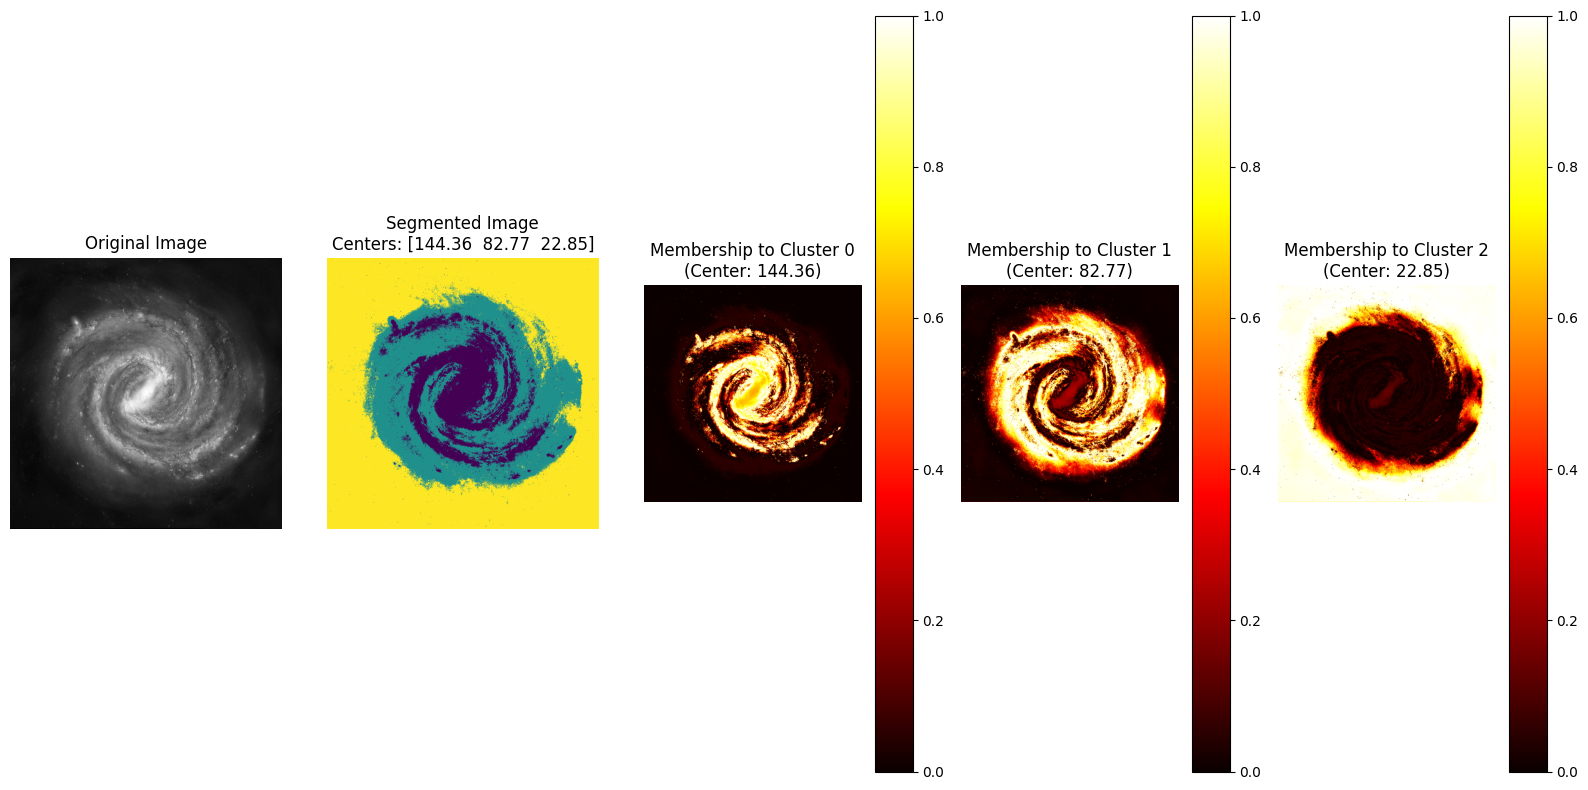

In [12]:
visualize_fcm_results(image_array, U_final, C_final, k)

###Plotting

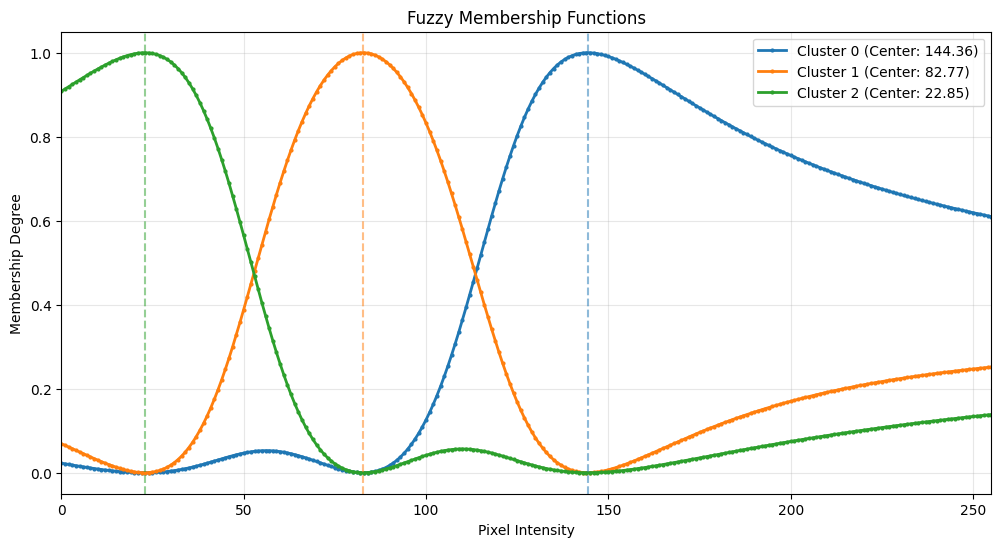

In [13]:
# After visualize_fcm_results
plot_membership_functions(points, U_final, C_final, k)

# Part 2 : HSV Image

## Calculate Cluster Centers

In [14]:
def calculate_cluster_centers_colored_image(U, points, k, m):
    if len(points.shape) == 1:
        raise ValueError("Input points should be 2D for color images.")
    else:
        n_features = points.shape[1]
        C = np.zeros((k, n_features))
        for j in range(k):
            weights = U[:, j] ** m
            # weights has shape (N,) but weights[:, np.newaxis] has shape (N, 1) to be able to multiply with points of shape (N, 3)
            C[j] = np.sum(weights[:, np.newaxis] * points, axis=0) / np.sum(weights)

    return C

## Update Matrix U

In [20]:
def update_membership_matrix_colored_image(U, points, C, k, m):
    for i in range(points.shape[0]):
        for j in range(k):
            # euclidean distance in 3D is np.linalg.norm vs np.abs in 1D
            d_1 = np.linalg.norm(points[i] - C[j])

            sum_ratios = 0
            for l in range(k):
                d_2 = np.linalg.norm(points[i] - C[l])

                if d_2 == 0:
                    sum_ratios = float('inf')
                    break

                ratio = (d_1 / d_2)**(2/(m-1))
                sum_ratios += ratio

            if d_1 == 0:
                U[i, j] = 1.0
            else:
                U[i, j] = 1.0 / sum_ratios

    return U

## FCM
Exactly the same algorithm :

**FCM(points,U, k, m, max_iter=100, tol=1e-4)**

In [21]:
def FCM(points,U, k, m, max_iter=100, tol=1e-4):
  for i in range(max_iter):
    # saving current U
    U_old = U.copy()

    C = calculate_cluster_centers_colored_image(U, points,k,m)

    U = update_membership_matrix_colored_image(U, points, C, k, m)

    # check convergence
    if np.max(np.abs(U - U_old)) < tol:
      print(f"Converged at iteration {i}")
      break

  return U, C

## Visualisation

In [16]:
def visualize_fcm_results_colored_image(image_array, U_final, C_final, k, is_RGB=False):

    plt.figure(figsize=(16, 8))

    # 1. Original image
    plt.subplot(1, k+2, 1)

    if is_RGB :
      image_rgb = image_array

    else:
      # Convert HSV back to RGB for display
      image_rgb = cv2.cvtColor(image_array, cv2.COLOR_HSV2RGB)

    plt.imshow(image_rgb)
    plt.title('Original Image (RGB)')

    plt.axis('off')

    # 2. Segmented image
    labels = np.argmax(U_final, axis=1)
    segmented = labels.reshape(image_array.shape[:2])

    plt.subplot(1, k+2, 2)
    plt.imshow(segmented, cmap='viridis')
    if len(C_final.shape) == 1:
        plt.title(f'Segmented Image\nCenters: {C_final.round(2)}')
    else:
        plt.title(f'Segmented Image\n{k} clusters')
    plt.axis('off')

    # 3. Heatmaps
    for j in range(k):
        plt.subplot(1, k+2, j+3)
        membership_j = U_final[:, j].reshape(image_array.shape[:2])
        plt.imshow(membership_j, cmap='hot', vmin=0, vmax=1)
        if len(C_final.shape) == 1:
            plt.title(f'Membership to Cluster {j}\n(Center: {C_final[j]:.2f})')
        else:
            plt.title(f'Membership to Cluster {j}\n(H:{C_final[j,0]:.1f}, S:{C_final[j,1]:.1f}, V:{C_final[j,2]:.1f})')
        plt.colorbar()
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Main

### Load image

In [17]:
image_path = "/content/milky-way.jpg"
image_bgr = cv2.imread(image_path)
# BGR to HSV
image_array = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# Reshape to (n_pixels, 3) where each row is [H, S, V]
height, width, channels = image_array.shape
points = image_array.reshape(-1, channels)

### initialisation

In [18]:
k = 3
m = 2.0
U = np.random.rand(points.shape[0],k)
U = U / U.sum(axis=1, keepdims=True)

### Run Algo

In [22]:
U_final, C_final = FCM(points, U, k, m)

print(f"Final cluster centers (HSV):\n{C_final}")

Converged at iteration 44
Final cluster centers (HSV):
[[128.8322835   40.59207039 132.47636113]
 [109.3634199  121.18238807  29.09892996]
 [114.23555763  65.43494077  67.03872409]]


### Visulatisation

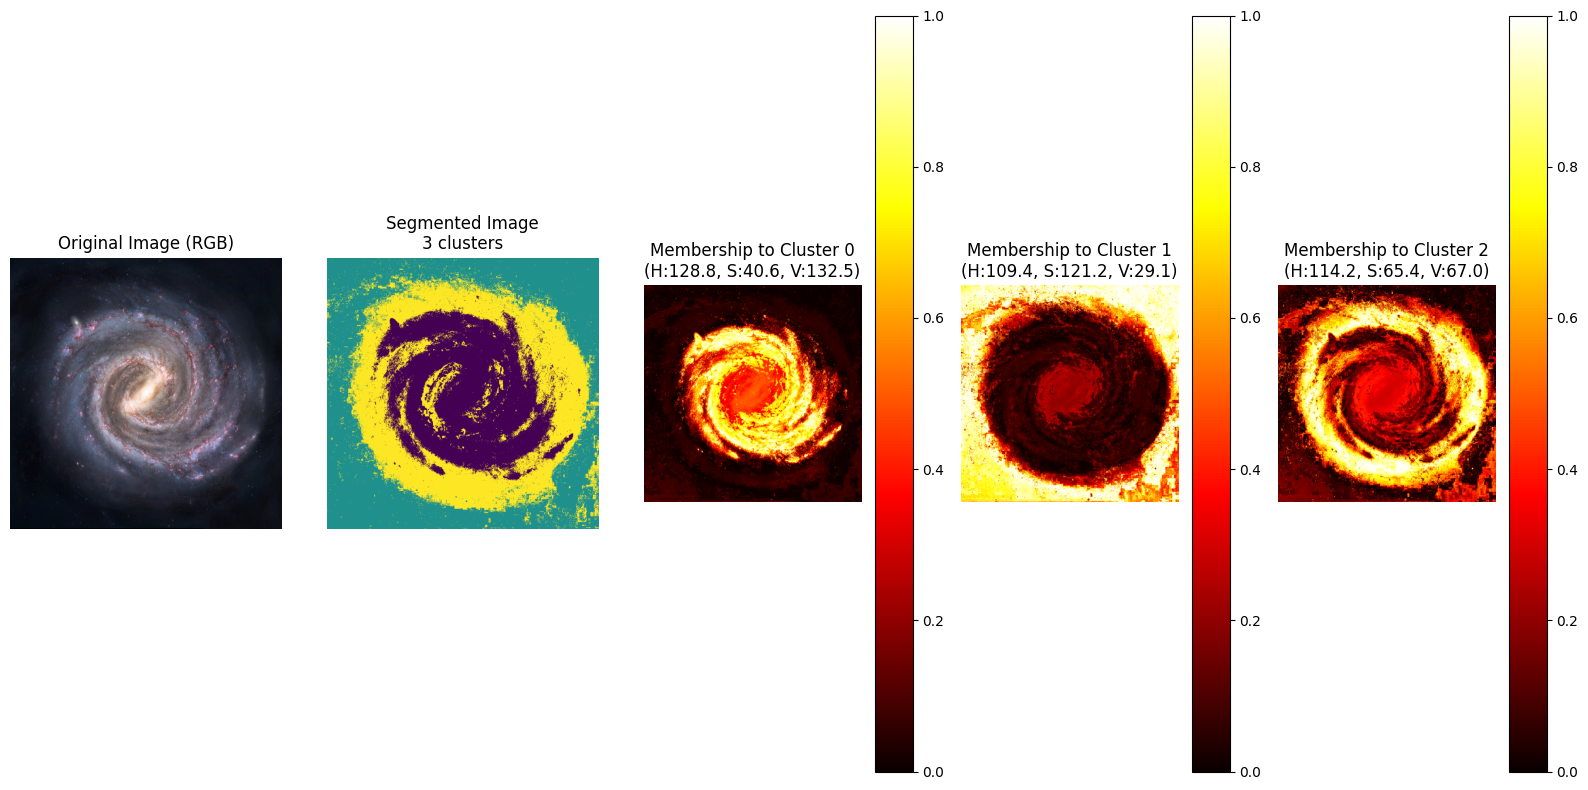

In [23]:
visualize_fcm_results_colored_image(image_array, U_final, C_final, k)

In [ ]:
image_path = "/content/milky-way.jpg"
image_bgr = cv2.imread(image_path)
# BGR to RGB
image_array = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Reshape to (n_pixels, 3)
height, width, channels = image_array.shape
points = image_array.reshape(-1, channels)

In [ ]:
k = 3
m = 2.0
U = np.random.rand(points.shape[0],k)
U = U / U.sum(axis=1, keepdims=True)

In [ ]:
U_final, C_final = FCM(points, U, k, m)

print(f"Final cluster centers (HSV):\n{C_final}")

In [ ]:
visualize_fcm_results_colored_image(image_array, U_final, C_final, k)